### calculate the SA signal for a given slit PA
### based on https://learn.astropy.org/tutorials/PVDiagramPlotting.html

In [70]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support
from astropy import units as u
from astropy import wcs
from astropy.io import fits  

from spectral_cube import SpectralCube
from pvextractor import extract_pv_slice, Path
from astropy.visualization import (AsinhStretch, LogStretch, ImageNormalize)

%matplotlib inline

In [71]:
# slit position angle in degrees, E of N
slitPA = 60

In [72]:
if slitPA < 0 or slitPA > 360:
    print('slitPA must be between 0 and 360')
    sys.exit()

In [73]:
path = "./radlite/"
filename = "radlite_image.fits"

f = fits.open(path+filename)
continuum = f[1].data
line = f[2].data
hd = f[2].header
wave = hd['WAVELEN']    # microns

In [74]:
# fill in the hole in the continuum image since this otherwise messes up the slit image and spectroastrometry
# (effectively a star and/or convolution by the PSF would do this in practice)
# just do this by making the central region constant; adjust the area manually
icen = int(hd['CRPIX1'])
jcen = int(hd['CRPIX2'])
ifill = 2
jfill = 2
median_continuum = np.nanmedian(continuum[jcen-jfill:jcen+jfill, icen-ifill:icen+ifill])
for i in range(icen-ifill, icen+ifill+1):
    for j in range(jcen-jfill, jcen+jfill+1):
        continuum[j, i] = median_continuum

In [75]:
cube = SpectralCube(data=line+continuum, wcs=wcs.WCS(hd)) 
flux = cube.moment0().value
norm = ImageNormalize(vmin=0, vmax=flux.max(), stretch=LogStretch())

In [76]:
# define path and direction starting from north
nx = cube.header['NAXIS1']
ny = cube.header['NAXIS2']
i0 = cube.header['CRPIX1']
j0 = cube.header['CRPIX2']

reverse = False
if slitPA >= 180:
    slitPA -= 180
    reverse = True

if np.abs(slitPA-90) < 1:
    path_start = (0, j0)
    path_end = (nx-1, j0)
elif (slitPA <= 45) or (slitPA >= 135):
    t = np.tan(np.radians(slitPA))
    path_start = (i0-(ny-1-j0)*t, ny-1)
    path_end = (i0+j0*t, 0)
else:
    t = np.tan(np.radians(slitPA))
    path_start = (0, j0+i0/t)
    path_end = (nx-1, j0-(nx-1-i0)/t)

if reverse:
    path_start, path_end = path_end, path_start
    
path = Path([path_start, path_end], width=0.01*u.arcsec)

/Users/jpw/opt/anaconda3/lib/python3.9/site-packages/pvextractor/geometry/path.py:262: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches.append(MPLPolygon(list(zip(poly.x, poly.y)), **kwargs))


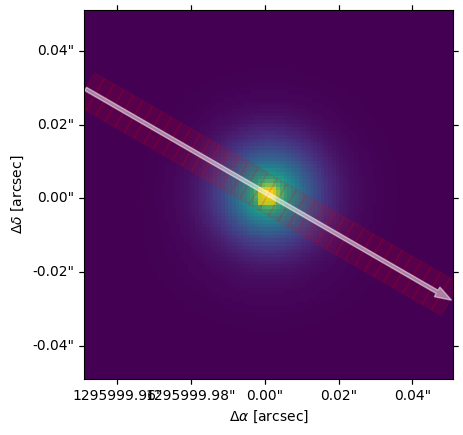

In [77]:
# show moment 0 image and slit path
ax = plt.subplot(111, projection=cube.wcs.celestial)
ax.imshow(flux, norm=norm, origin='lower')

path.show_on_axis(ax, spacing=3, color='r', alpha=0.1)
ax.arrow(path_start[0], path_start[1], \
         path_end[0]-path_start[0], path_end[1]-path_start[1], \
         color='w', length_includes_head=True, width=1, alpha=0.5)

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec)
ax1 = ax.coords[1]
ax1.set_format_unit(u.arcsec)

ax.set_xlabel(r"$\Delta\alpha$ [arcsec]")
ax.set_ylabel(r"$\Delta\delta$ [arcsec]")

In [78]:
pv = extract_pv_slice(cube=cube, path=path, spacing=1)
ns = pv.header['NAXIS1']
nv = pv.header['NAXIS2']
is0 = pv.header['CRPIX1']
iv0 = pv.header['CRPIX2']
ds = pv.header['CDELT1'] * 3.6e6    # milli-arcsec
dv = pv.header['CDELT2'] / 1000     # km/s
s0 = pv.header['CRVAL1'] * 3.6e6
v0 = pv.header['CRVAL2'] / 1000
s = (np.arange(ns) - ns/2 + 0.5) * ds   # make this zero at the center
v = v0 + (np.arange(nv) - iv0) * dv

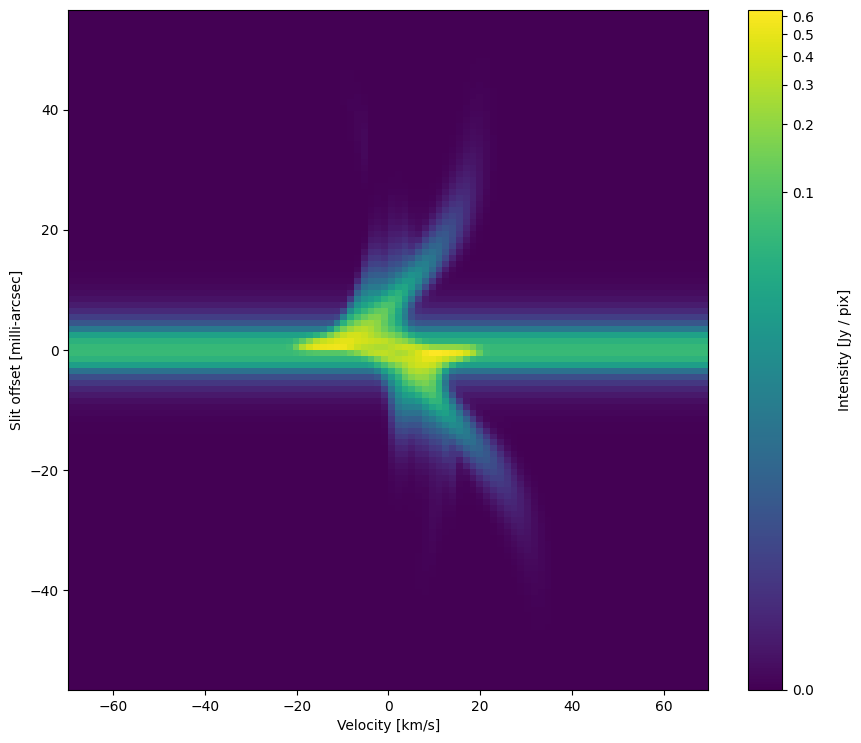

In [79]:
SA_image = pv.data.T

im_bounds = [v.min(), v.max(), s.min(), s.max()]
v_lims = [v.min(), v.max()]
slit_lims = [s.min(), s.max()]

norm = ImageNormalize(vmin=0, vmax=SA_image.max(), stretch=LogStretch())

fig, ax = plt.subplots(figsize=(10, 8))
p = ax.imshow(SA_image, origin='lower', cmap='viridis', norm=norm, extent=im_bounds, aspect='auto')

ax.set_ylim(slit_lims)
ax.set_xlim(v_lims)
ax.set_ylabel('Slit offset [milli-arcsec]')
ax.set_xlabel('Velocity [km/s]')
cb = plt.colorbar(p, ax=ax, pad=0.05)
cb.set_label(r'Intensity [Jy / pix]', rotation=90, labelpad=17)
plt.subplots_adjust(left=0.13, right=0.93, bottom=0.13, top=0.98)

In [80]:
# calculate the mean slit position (and std) at each velocity = spectroastrometric signal
SA = np.zeros(nv)
SA_err = np.zeros(nv)
for i in range(nv):
    # is the velocity vector increating or decreasing with index?
    if v[1]-v[0] > 0:
        Iv = SA_image[:, i]
    else:
        Iv = SA_image[:, nv-1-i]
    Ivsum = np.nansum(Iv)
    mu = np.nansum(s * Iv) / Ivsum
    SA[i] = mu
    SA_err[i] = np.sqrt((np.nansum(s**2 * Iv) / Ivsum) - mu**2)

Text(0, 0.5, 'Slit offset [milli-arcsec]')

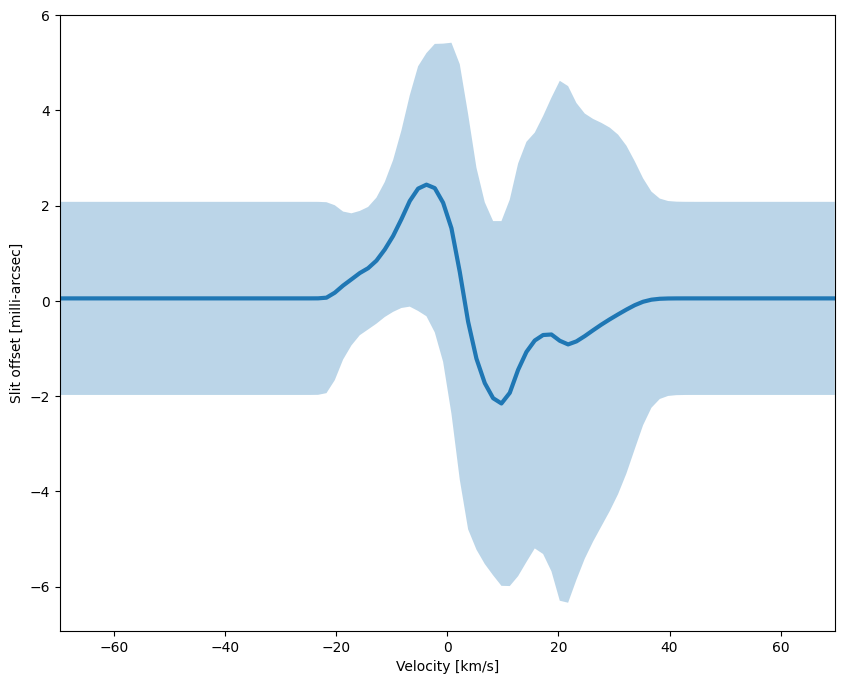

In [81]:
fig, ax = plt.subplots(figsize=(10, 8))
#ax.step(v, SA)

ax.plot(v, SA, lw=3)
plt.fill_between(v, SA-SA_err, SA+SA_err, alpha=0.3)

ax.set_xlim(v_lims)
ax.set_xlabel('Velocity [km/s]')
ax.set_ylabel('Slit offset [milli-arcsec]')
